In [2]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

# Data Preprocessing

In [3]:
DATA_PATH = os.path.realpath("../WESAD")

In [4]:
class Subject:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        """Returns data measured by the E4 Empatica"""

        data = self.data['signal']['wrist']
        return data
    
    def get_subject_dataframe(self):
        """Returns a dataframe with the preprocessed data of the subject"""
        wrist_data = self.get_wrist_data()
        bvp_signal = wrist_data['BVP'][:,0]
        eda_signal = wrist_data['EDA'][:,0]
        acc_x_signal = wrist_data['ACC'][:,0]
        acc_y_signal = wrist_data['ACC'][:,1]
        acc_z_signal = wrist_data['ACC'][:,2]
        temp_signal = wrist_data['TEMP'][:,0]
        # Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
        eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
        temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
        acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
        acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
        acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))
        label_df = pd.DataFrame(self.labels, columns=['label'])
        label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
        label_df.index = pd.to_datetime(label_df.index, unit='s')
        data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
        df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
        df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.join(label_df)
        df['label'] = df['label'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)
        df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])
        df.reset_index(drop=True, inplace=True)
        df = (df-df.min())/(df.max()-df.min()) # Normalize data (no train test leakage since data frame per subject) 
        return df


In [5]:
s2 = Subject(DATA_PATH, 2)

In [6]:
s2.get_subject_dataframe()

/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')


,BVP,EDA,ACC_x,ACC_y,ACC_z,TEMP,label
0,0.536850,0.993856,0.661565,0.717624,0.545219,0.950902,0.0
1,0.548782,0.995152,0.676264,0.736944,0.507794,0.950913,0.0
2,0.560715,0.996392,0.683334,0.736449,0.507154,0.950923,0.0
3,0.571374,0.997521,0.691702,0.691200,0.545094,0.950932,0.0
4,0.580215,0.998489,0.674626,0.642324,0.583283,0.950940,0.0
...,...,...,...,...,...,...,...
135739,0.533648,0.089840,0.499794,0.927696,0.460655,0.441595,0.0
135740,0.536857,0.089739,0.500468,0.929406,0.464332,0.441532,0.0
135741,0.540788,0.089649,0.503081,0.929464,0.466159,0.441435,0.0
135742,0.544653,0.089569,0.504822,0.929406,0.464332,0.441301,0.0


In [7]:
def create_subjects_data() -> dict:
    # Create a dictionary with all the subjects and belonging dataframes
    subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
    subjects_data = {}
    for subject_num in subjects:
        subject = Subject(DATA_PATH, subject_num)
        subjects_data[subject.name] = subject.get_subject_dataframe()

    return subjects_data

### Window

1. Creating the windows
2. Create subwindows from the windows
3. Calculate the fft of the subwindows
4. Average the subwindows


In [8]:
# Subwindow length of the biosignals
signal_subwindow_dict = {
    'ACC_x': 7,
    'ACC_y': 7,
    'ACC_z': 7,
    'BVP': 30,
    'EDA': 30,
    'TEMP': 35
    }

In [9]:
# most frequent element in list
def most_common(lst):
    return max(set(lst), key=lst.count)

In [10]:
def create_windows(df: pd.DataFrame) -> tuple[pd.DataFrame,list]:
    """Creates windows from the dataframe and returns the windows and the labels.
    If the window is assigned to multiple labels, the most common label is chosen for that period.

    Args:
        df (pd.DataFrame): Subject DataFrame

    Returns:
        tuple[pd.DataFrame,list]: Windows representing the activity of the subject in one minute and the corresponding labels.
    """

    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    windows, labels = zip(*[(df[i:i+window_len], int(most_common(df['label'][i:i+window_len].to_list()))) for i in range(0,df.shape[0],window_len)])
    return windows, labels

In [11]:
def create_subwindows(df: pd.DataFrame, signal_subwindow_len: int, signal_name: str) -> list:
    """The function creates subwindows from the windows.

    Args:
        df (pd.DataFrame): Windows representing the activity of the subject in one minute.
        signal_subwindow_len (int): Length of the subwindows.
        signal_name (str): Name of the signal.

    Returns:
        list: Subwindows of the signal in the window.
    """
    subwindow_len = 64 * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25
    subwindows = []

    for i in range(0, window_len, window_shift):
        if i + subwindow_len <= window_len:
            subwindow = df[signal_name][i:i+subwindow_len]
            subwindows.append(subwindow)
    return subwindows
            

In [12]:
def fft_subwindows(subwindows: list, duration: int, f_s: int) -> list:
    """Calculates the fft of the subwindows.

    Args:
        subwindows (list): C
        duration (int): _description_
        f_s (int): _description_

    Returns:
        list: Fft coefficients of the subwindows.
    """
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        N = f_s * duration
        freq = scipy.fft.fftfreq(N, 1/f_s)

        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])

        # Sort descending amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        freqs.append(freq)
        yfs.append(amps)
    return np.asarray(freqs), np.asarray(yfs)
    

In [13]:
def average_window(subwindows_fft: list) -> list:
    """Calculates the average of the fft coefficients of the subwindows.

    Args:
        subwindows_fft (list): List of fft coefficients of the subwindows.

    Returns:
        list: Average of the fft coefficients of the subwindow for signals.
    """
    len_yfs = len(subwindows_fft[0])
    avg_yfs = []
    for i in range(len_yfs):
        i_yfs = []
        for yf in subwindows_fft:
            try:
                i_yfs.append(yf[i])
            except IndexError:
                pass
        avg_yfs.append(sum(i_yfs)/len(i_yfs))
    return avg_yfs

In [14]:
def create_preprocessed_subjects_data(subjects_data: dict) -> dict:
# Creates averaged windows for all subjects from dataframes

    subjects_preprosessed_data = {}
    for subject_name, subject_df in subjects_data.items():
        subjects_preprosessed_data[subject_name] = {}
        windows, labels = create_windows(subject_df)
        yfs_per_min_for_signal = {}
        X = []
        for i in range(0,len(windows) - 1):
            for signal in signal_subwindow_dict.keys():

                duration_in_sec = signal_subwindow_dict[signal]

                subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
                freqs, yfs = fft_subwindows(subwindows, duration_in_sec, 64)
                yfs_average = average_window(yfs)[:210]
                yfs_per_min_for_signal[signal] = yfs_average
                
            X.append(pd.DataFrame(yfs_per_min_for_signal).T)
        y = list(labels[:len(windows)-1])
        subjects_preprosessed_data[subject_name]['X'] = X
        subjects_preprosessed_data[subject_name]['y'] = y
    
    return subjects_preprosessed_data


In [15]:
subjects_data = create_subjects_data()
subjects_preprocessed_data = create_preprocessed_subjects_data(subjects_data)

/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')
/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')
/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')
/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.

In [16]:
def get_subject_window_data(subjects_preprosessed_data: dict) -> tuple[list, list]:
    # Created train and test data for leave one out cross validation
    all_subjects_X = []
    all_subjects_y = []
    for subject_name, subject_data in subjects_preprosessed_data.items():
        all_subjects_X.append(subject_data['X'])
        all_subjects_y.append(subject_data['y'])
    
    return (all_subjects_X, all_subjects_y)


In [17]:
# all_subjects_X, all_subjects_y = get_subject_window_data(subjects_preprocessed_data)

![OS_Sensors](../images/os_sensors.png)

# Model

In [18]:
#import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from lightgbm import LGBMClassifier

### Build model

In [19]:
def build_model(num_signals: int, num_output_class: int) -> tf.keras.models.Sequential:
    # Define the model architecture
    model = tf.keras.Sequential()
    # input_shape = 14 Signale (bei uns max. 6) X 210 Inputs (aus Tabelle nach Fourier)
    model.add(tf.keras.layers.InputLayer(input_shape=[num_signals, 210, 1]))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same')) 
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    # Anzahl der Units = Anzahl der Klassen (2 - non-stress vs stress)
    model.add(tf.keras.layers.Dense(units=num_output_class, activation='sigmoid')) # sigmoid statt softmax, da nur 2 Klassen

    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

### Train model

In [ ]:
def create_subjects_data_df(subject_numbers: list) -> pd.DataFrame:
    all_processed_windows_list = []
    

    raw_subjects_data_dict = {}
    for subject_num in subject_numbers:
        subject = Subject(DATA_PATH, subject_num)
        raw_subjects_data_dict[subject.name] = subject.get_subject_dataframe()

    # Now, preprocess these raw subject data into windows and features
    preprocessed_data_dict = create_preprocessed_subjects_data(raw_subjects_data_dict)

    # Now, flatten the preprocessed data (list of feature DataFrames per subject) into one list
    # and add subject_id and label columns for the final DataFrame
    for subject_name, data in preprocessed_data_dict.items():
        subject_id = int(subject_name.replace('S', ''))
        windows_X_list = data['X'] # This is a list of DataFrames, one DataFrame per window
        labels_list = data['y']    # This is a list of labels for each window

        for window_idx, window_df_features in enumerate(windows_X_list):
            # Flatten the window's feature DataFrame into a 1D Series for a single row
            flattened_features_series = window_df_features.stack() # Stacks columns into a single Series
            
            # Create a temporary Series to add subject_id and label
            temp_series = pd.Series({
                'subject_id': subject_id,
                'label': labels_list[window_idx]
            })
            
            # Combine the flattened features and the temp_series
            # Use .loc to avoid re-indexing issues if column names clash (though unlikely here)
            combined_series = pd.concat([flattened_features_series.reset_index(drop=True), temp_series.reset_index(drop=True)])
            
            # Since stack creates MultiIndex, we need to handle column names properly.
            # A cleaner way is to convert to array first.
            row_data = window_df_features.values.flatten().tolist()
            row_data.append(subject_id)
            row_data.append(labels_list[window_idx])
            
            all_processed_windows_list.append(row_data)

    # Dynamically create column names
    # Get feature names from the first window's DataFrame
    if all_processed_windows_list:
        first_window_df_features = preprocessed_data_dict[next(iter(preprocessed_data_dict))]['X'][0]
        feature_columns = [f'{sig}_feature_{i}' for sig in first_window_df_features.index for i in range(first_window_df_features.shape[1])]
        
        columns = feature_columns + ['subject_id', 'label']
        full_dataset_df = pd.DataFrame(all_processed_windows_list, columns=columns)
    else:
        full_dataset_df = pd.DataFrame() # Empty DataFrame if no data

    return full_dataset_df

# groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
subjects_to_analyze = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

# Create the full dataset as a single DataFrame
full_data_df = create_subjects_data_df(subjects_to_analyze)

# Separate features (X), labels (y), and groups (subject_id)
# Drop 'subject_id' and 'label' columns from X_full_df
X_full_df = full_data_df.drop(columns=['subject_id', 'label'])
y_full_series = full_data_df['label']
groups = full_data_df['subject_id'] # This column defines the groups for LOSO

# Convert to NumPy arrays for LeaveOneGroupOut
X_full_np = X_full_df.values # Get the numerical values as a NumPy array
y_full_np = y_full_series.values
groups_np = groups.values

num_estimators_tree = 100 # Estimators for tree-based models

models_results = {
    'XGBoost': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'LightGBM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
}

model_save_base_dir = "lgbmmodels"
os.makedirs(model_save_base_dir, exist_ok=True)

print("Starting Leave-One-Subject-Out Cross-Validation for models :")

logo = LeaveOneGroupOut()

# The split method directly operates on the full NumPy arrays
for fold_idx, (train_indices, test_indices) in enumerate(logo.split(X_full_np, y_full_np, groups=groups_np)):
    X_train = X_full_np[train_indices]
    y_train = y_full_np[train_indices]
    X_test = X_full_np[test_indices]
    y_test = y_full_np[test_indices]

    # Get the actual subject ID for the test set for logging
    # Use the first subject_id from the test set indices to identify the test subject for this fold
    current_test_subject_id = groups_np[test_indices[0]] if len(test_indices) > 0 else "N/A"

    print(f'\n--- Fold {fold_idx+1}: Testing on subject S{current_test_subject_id} ---')

    # Calculate class weight for imbalanced dataset
    class_0_count_train = np.sum(y_train == 0)
    class_1_count_train = np.sum(y_train == 1)
    weight_balance = class_0_count_train / class_1_count_train if class_1_count_train > 0 else 1

    ### XGBoost Model Training and Evaluation ###
    print("Training XGBoost model...")
    xgboost_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=num_estimators_tree,
        random_state=42,
        scale_pos_weight=weight_balance
    )
    xgboost_model.fit(X_train, y_train) # X_train and y_train are already NumPy arrays

    # Evaluate XGBoost
    xgboost_pred = xgboost_model.predict(X_test) # X_test is already NumPy array
    xgboost_accuracy = accuracy_score(y_test, xgboost_pred)
    xgboost_precision = precision_score(y_test, xgboost_pred, zero_division=0)
    xgboost_recall = recall_score(y_test, xgboost_pred, zero_division=0)
    xgboost_f1 = f1_score(y_test, xgboost_pred, zero_division=0)

    models_results['XGBoost']['accuracy'].append(xgboost_accuracy)
    models_results['XGBoost']['precision'].append(xgboost_precision)
    models_results['XGBoost']['recall'].append(xgboost_recall)
    models_results['XGBoost']['f1'].append(xgboost_f1)
    print(f"XGBoost - Accuracy: {xgboost_accuracy:.4f}, F1: {xgboost_f1:.4f}")

    ### LightGBM Model Training and Evaluation ###
    print("Training LightGBM model...")
    lightgbm_model = LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        n_estimators=num_estimators_tree,
        random_state=42,
        is_unbalance=True
    )
    lightgbm_model.fit(X_train, y_train) # X_train and y_train are already NumPy arrays

    # --- Saving the LightGBM model using pickle ---
    model_filename = os.path.join(model_save_base_dir, f'lightgbm_model_S{current_test_subject_id}.pkl')
    with open(model_filename, 'wb') as file:
        pickle.dump(lightgbm_model, file)
    print(f"LightGBM model for S{current_test_subject_id} saved to {model_filename}")
    # --- End Saving ---
    
    # Evaluate LightGBM
    lightgbm_pred = lightgbm_model.predict(X_test) # X_test is already NumPy array
    lightgbm_accuracy = accuracy_score(y_test, lightgbm_pred)
    lightgbm_precision = precision_score(y_test, lightgbm_pred, zero_division=0)
    lightgbm_recall = recall_score(y_test, lightgbm_pred, zero_division=0)
    lightgbm_f1 = f1_score(y_test, lightgbm_pred, zero_division=0)

    models_results['LightGBM']['accuracy'].append(lightgbm_accuracy)
    models_results['LightGBM']['precision'].append(lightgbm_precision)
    models_results['LightGBM']['recall'].append(lightgbm_recall)
    models_results['LightGBM']['f1'].append(lightgbm_f1)
    print(f"LightGBM - Accuracy: {lightgbm_accuracy:.4f}, F1: {lightgbm_f1:.4f}")

print("\n\n# Overall Evaluation Results (Average across all subjects)")
for model_name, metrics in models_results.items():
    print(f"\n--- {model_name} ---")
    print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
    print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
    print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
    print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

print("\n# Detailed Subject-wise Evaluation Results")
print(f'Subject\t\t XGB Acc\tXGB F1\t\tLGBM Acc\tLGBM F1')
print("**************************************************************************************************")
for i in range(len(subjects_to_analyze)): # Use subjects_to_analyze for iterating subject IDs
    s_id = subjects_to_analyze[i]
    print(f'S{s_id}\t\t {models_results["XGBoost"]["accuracy"][i]:.5f}\t\t{models_results["XGBoost"]["f1"][i]:.5f}\t\t'
          f'{models_results["LightGBM"]["accuracy"][i]:.5f}\t\t{models_results["LightGBM"]["f1"][i]:.5f}')
print("**************************************************************************************************")
    

/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')
/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')
/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['label'] = df['label'].fillna(method='ffill')
/var/folders/lw/14dpn8b91z99svtdtfqnx09800tlp4/T/ipykernel_72860/1837807064.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.

Starting Leave-One-Subject-Out Cross-Validation for models :

--- Fold 1: Testing on subject S2 ---
Training XGBoost model...


/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.8857, F1: 0.7778
Training LightGBM model...
[LightGBM] [Info] Number of positive: 148, number of negative: 362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215460
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290196 -> initscore=-0.894432
[LightGBM] [Info] Start training from score -0.894432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.7714, F1: 0.6000
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215460
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288235 -> initscore=-0.903970
[LightGBM] [Info] Start training from score -0.903970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.9722, F1: 0.9524
Training LightGBM model...
[LightGBM] [Info] Number of positive: 148, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290766 -> initscore=-0.891666
[LightGBM] [Info] Start training from score -0.891666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.9444, F1: 0.9091
Training LightGBM model...
[LightGBM] [Info] Number of positive: 148, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290766 -> initscore=-0.891666
[LightGBM] [Info] Start training from score -0.891666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.9722, F1: 0.9524
Training LightGBM model...
[LightGBM] [Info] Number of positive: 148, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290766 -> initscore=-0.891666
[LightGBM] [Info] Start training from score -0.891666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.8333, F1: 0.7692
Training LightGBM model...
[LightGBM] [Info] Number of positive: 148, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290766 -> initscore=-0.891666
[LightGBM] [Info] Start training from score -0.891666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 1.0000, F1: 1.0000
Training LightGBM model...
[LightGBM] [Info] Number of positive: 148, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290766 -> initscore=-0.891666
[LightGBM] [Info] Start training from score -0.891666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.9722, F1: 0.9524
Training LightGBM model...
[LightGBM] [Info] Number of positive: 148, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290766 -> initscore=-0.891666
[LightGBM] [Info] Start training from score -0.891666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.9730, F1: 0.9524
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289370 -> initscore=-0.898445
[LightGBM] [Info] Start training from score -0.898445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.8649, F1: 0.8148
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289370 -> initscore=-0.898445
[LightGBM] [Info] Start training from score -0.898445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 1.0000, F1: 1.0000
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289370 -> initscore=-0.898445
[LightGBM] [Info] Start training from score -0.898445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.7838, F1: 0.5556
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289370 -> initscore=-0.898445
[LightGBM] [Info] Start training from score -0.898445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.8649, F1: 0.7368
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289370 -> initscore=-0.898445
[LightGBM] [Info] Start training from score -0.898445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.7838, F1: 0.4286
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289370 -> initscore=-0.898445
[LightGBM] [Info] Start training from score -0.898445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.5946, F1: 0.0000
Training LightGBM model...
[LightGBM] [Info] Number of positive: 147, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 1260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289370 -> initscore=-0.898445
[LightGBM] [Info] Start training from score -0.898445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/gnancy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


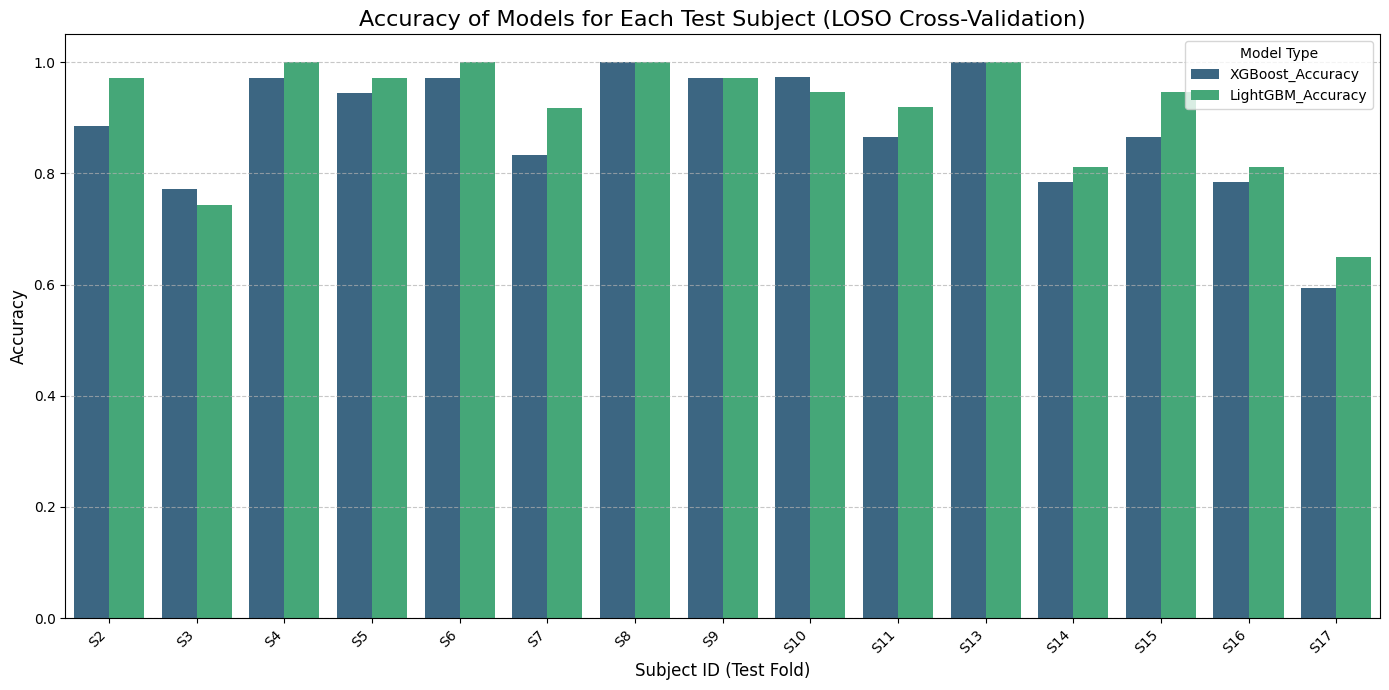

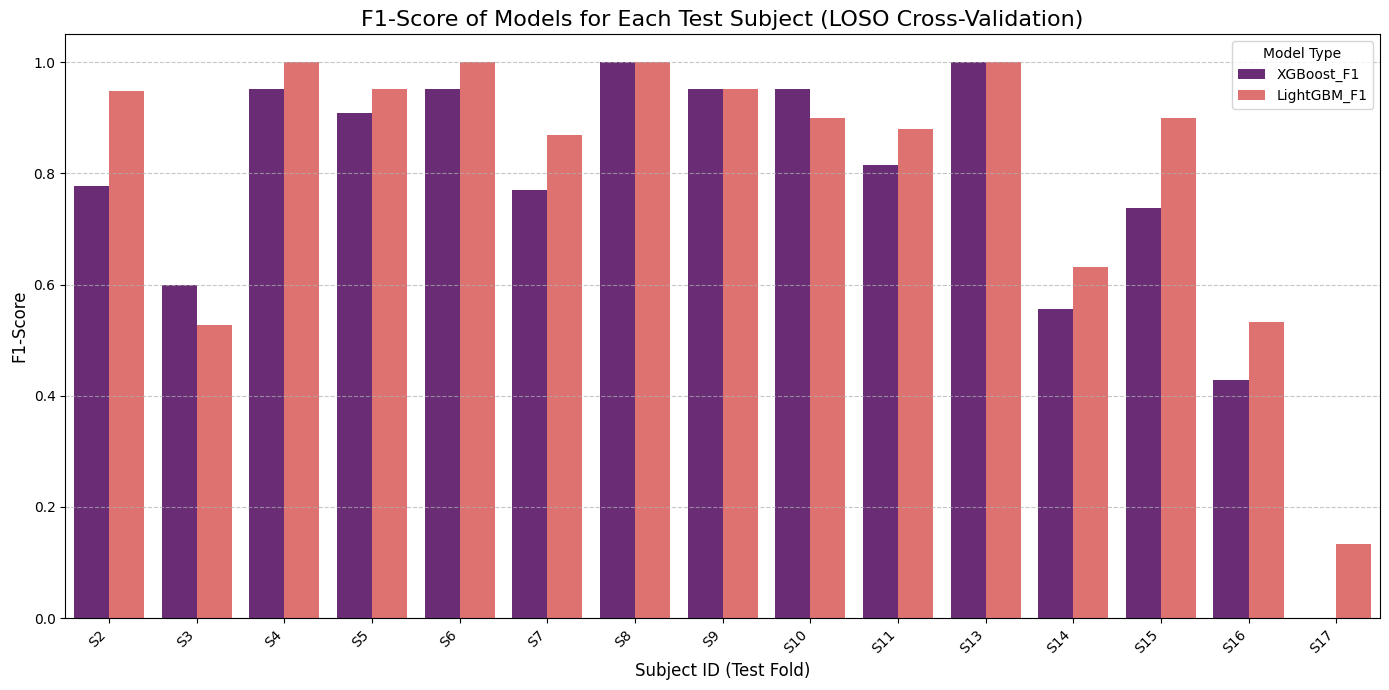

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



acc_data = {
    'Subject': [f'S{s_id}' for s_id in subjects_to_analyze],
    'XGBoost_Accuracy': models_results['XGBoost']['accuracy'],
    'LightGBM_Accuracy': models_results['LightGBM']['accuracy']
}
df_acc = pd.DataFrame(acc_data)

# Melt the DataFrame for Seaborn's barplot
df_acc_melted = df_acc.melt(id_vars='Subject', var_name='Model', value_name='Accuracy')

# Then, for F1-Score
f1_data = {
    'Subject': [f'S{s_id}' for s_id in subjects_to_analyze],
    'XGBoost_F1': models_results['XGBoost']['f1'],
    'LightGBM_F1': models_results['LightGBM']['f1']
}
df_f1 = pd.DataFrame(f1_data)

# Melt the DataFrame for Seaborn's barplot
df_f1_melted = df_f1.melt(id_vars='Subject', var_name='Model', value_name='F1-Score')

# --- Plotting ---

# Plot 1: Accuracy Comparison per Subject
plt.figure(figsize=(14, 7))
sns.barplot(x='Subject', y='Accuracy', hue='Model', data=df_acc_melted, palette='viridis')
plt.title('Accuracy of Models for Each Test Subject (LOSO Cross-Validation)', fontsize=16)
plt.xlabel('Subject ID (Test Fold)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.05) # Set y-limit from 0 to slightly above 1 for better visualization
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: F1-Score Comparison per Subject
plt.figure(figsize=(14, 7))
sns.barplot(x='Subject', y='F1-Score', hue='Model', data=df_f1_melted, palette='magma')
plt.title('F1-Score of Models for Each Test Subject (LOSO Cross-Validation)', fontsize=16)
plt.xlabel('Subject ID (Test Fold)', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.05) # Set y-limit from 0 to slightly above 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Unused CNN model

In [ ]:
all_subjects_X_os, all_subjects_y = get_subject_window_data(subjects_preprocessed_data)
# groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17] # ids for subjects in WESAD dataset


groups_set = [0, 1, 2]
subject_ids = [2, 3, 4] # ids for subjects in WESAD dataset
num_signals = len(['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP']) # Number of signals in the WESAD dataset measured by the empatica e4
num_output_class = 2 # Number of output classes (2 - non-stress vs stress)
num_epochs = 100

all_acc_histories = []
all_loss_histories = []

for i in groups_set:
    test_index = groups_set[i]
    train_index = [x for x in groups_set if x != test_index]
    print(train_index, test_index)

    X_train = np.concatenate(np.array([all_subjects_X_os[x] for x in train_index], dtype=object))
    y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index], dtype=object))
    X_test = all_subjects_X_os[test_index]
    y_test = all_subjects_y[test_index]
    
    weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)

    y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

    tf.keras.backend.clear_session()

    model = build_model(num_signals, num_output_class)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"models/{os}/wesad_{os}_binary_s{subject_ids[test_index]}_{num_epochs}.h5",  # Path to save the model file
        monitor="loss", # The metric name to monitor
        save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss",     # Quantity to be monitored.
        min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=100,        # Number of epochs with no improvement after which training will be stopped.
    )

    history = model.fit(
        X_train, 
        y_train,
        epochs=num_epochs, 
        batch_size=50,
        verbose=1,
        class_weight={0: 1, 1: weight_balance},
        callbacks = [checkpoint, early_stopping]
    )   
